In [1]:
import sys
from pathlib import Path
from os.path  import join
from src.config import DATA_DIR, CONFIG_DIR, MODELS_DIR
from omegaconf import OmegaConf
from src.external.hptr.src.data_modules.agent_centric import AgentCentricPreProcessing
from src.external.hptr.src.data_modules.ac_global import AgentCentricGlobal
from src.mimolm import InputProjections, EarlyFusionEncoder, MotionDecoder
import torch
import torch.nn.functional as F
import lightning as pl
from collections import OrderedDict
import torch.nn as nn
from tqdm import tqdm
import numpy as np
from src.modeling.modules.av2_metrics import (
    compute_world_ade,
    compute_world_fde,
    compute_world_brier_fde,
    compute_world_misses,
    compute_world_collisions
)
from src.external.hptr.src.utils.transform_utils import torch_pos2global
# Add the project root to sys.path
project_root = Path().resolve().parent  # Adjust as needed to point to the root folder
sys.path.append(str(project_root))

print(Path.cwd())  # Check if the path is added

2025-02-20 08:48:26.086 | INFO     | src.config:<module>:11 - PROJ_ROOT path is: /home/harshavardhan-patil/Work/Projects/mimolm
/home/harshavardhan-patil/Work/Projects/mimolm/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/harshavardhan-patil/Work/Projects/mimolm/notebooks


In [77]:
from src.external.hptr.src.data_modules.data_h5_av2 import DataH5av2
from src.mimolm import MimoLM
from lightning.pytorch.callbacks import LearningRateMonitor
import itertools

torch.set_printoptions(threshold=10000, sci_mode=False)
data_module = DataH5av2(DATA_DIR
                        , batch_size=1)
data_module.setup(stage="fit")
train_loader = data_module.train_dataloader()
# val_loader = data_module.val_dataloader()
sampling_rate = 2 #Hz
sampling_step = int(10 / sampling_rate)
max_delta = 18.0 #m
n_target = 8
preprocessor = nn.Sequential(OrderedDict([
            ('pre_1', AgentCentricPreProcessing(sampling_rate = sampling_rate,
                                        time_step_current=49, 
                                        n_target=n_target,
                                        n_other=48,
                                        n_map=512,
                                        mask_invalid=False)),
            ('pre_2', AgentCentricGlobal(sampling_rate = sampling_rate,
                                data_size=data_module.tensor_size_train,
                               time_step_current=49,
                                dropout_p_history=0.1, 
                                add_ohe=True,
                                pl_aggr=False,
                                pose_pe= {"agent": "xy_dir",
                                        "map": "mpa_pl"}))
                                        ]))

decoder = MotionDecoder(max_delta = max_delta, #meters
                                n_quantization_bins = 128,
                                n_verlet_steps = 13,
                                emb_dim = 256,
                                enc_dim = 128,
                                sampling_rate = sampling_rate,
                                n_time_steps = 110,
                                n_target = n_target, #should be same as AgentCentricProcessing
                                time_step_end = 49,
                                dropout_rate = 0.2,
                                n_rollouts = 1,
                                n_heads = 2,
                                n_layers = 2,)


def create_vocabulary(n_verlet_steps):
    # bins set for 2Hz, 18.0m, 192bins
    central_bins = torch.linspace(-0.1, 0.1, 41)
    medium_pos = torch.linspace(0.1, 3.0, 46)
    medium_neg = torch.linspace(-3.0, -0.1, 26)
    tail_pos = torch.linspace(3.0, 18.0, 52)
    tail_neg = torch.linspace(-18.0, -3.0, 31)
    bins = torch.unique(torch.cat([
        tail_neg,
        medium_neg,
        central_bins,
        medium_pos,
        tail_pos
    ]))
    #verlet_wrapper = torch.tensor([-16, -8, -4, -2, -1,  0,  1,  2,  4,  8,  24,  36,  48])
    #verlet_wrapper = torch.tensor([-12, -8, -4, -2, -1,  0,  1,  2,  4,  8,  12,  16,  24])
    verlet_wrapper = torch.tensor([-10, -8, -6, -4, -2, -1, 0, 1, 2, 4, 6, 8, 10])
    cartesian_product = torch.tensor(list(itertools.product(verlet_wrapper, verlet_wrapper)))
    vocabulary = torch.cat((cartesian_product, torch.tensor([float('-inf'), float('-inf')]).unsqueeze(0)), dim=0) # masking token
    return vocabulary, bins, verlet_wrapper


def tokenize_motion(motion_tokens, pos_bins, verlet_wrapper, n_verlet_steps, max_delta):
    n_batch, n_agents, n_steps, _ = motion_tokens.shape
    # delta_x and delta_y
    motion_tokens = torch.diff(motion_tokens, dim=2, prepend=motion_tokens[:, :, :1, :])
    # for masking transitional diffs
    invalid_indices = torch.cat(((motion_tokens < -max_delta).nonzero()
                                 , (motion_tokens > max_delta).nonzero())) 
    
    # MotionLM uses greedy search, using bucketize here for simplicity
    x_tokens = torch.bucketize(motion_tokens[:, :, :, 0].contiguous(), pos_bins,)
    y_tokens = torch.bucketize(motion_tokens[:, :, :, 1].contiguous(), pos_bins,)
    prev_bins = torch.cat((x_tokens.unsqueeze(-1), y_tokens.unsqueeze(-1)), dim=-1)
    x_last = x_tokens[:, :, -1].unsqueeze(-1)
    y_last = y_tokens[:, :, -1].unsqueeze(-1)
    x_tokens_diff = x_tokens[:, :, 2:] - (2 * x_tokens[:, :, 1:-1] - x_tokens[:, :, :-2])#torch.diff(x_tokens, dim=2, prepend = x_tokens[:, :, :1])
    y_tokens_diff = y_tokens[:, :, 2:] - (2 * y_tokens[:, :, 1:-1] - y_tokens[:, :, :-2])#torch.diff(y_tokens, dim=2, prepend = y_tokens[:, :, :1])
    # Verlet Wrapper (see paper): The idea is that velocity of cars changes smoothly, 
    # so we can use a smaller vocabulary to represent the relative motion between the last two time steps.
    # e.g: max_delta: float = 4.0,  n_quantization_bins: int = 128,  n_verlet_steps: int = 13, 10 Hz predicition, 
    # the max speed for the modeled agent is 4 x 10 = 40 m/s. 
    # 0 to max steps in Verlet Wrapper represents the max distance delta modeled. 
    # THIS IS NO LONGER THE CASE WITH NON-UNIFORM BINS 
    # For -6 to 6 with 13 steps in Verlet and for 128 bins, the max acceleration between timesteps is 3.1 m/s^2.
    x_tokens = torch.clamp(torch.bucketize(x_tokens_diff, verlet_wrapper,), min = 0, max = n_verlet_steps - 1)
    y_tokens = torch.clamp(torch.bucketize(y_tokens_diff, verlet_wrapper,), min = 0, max = n_verlet_steps - 1)
    # collapse the per-coordinate actions to a single integer indexing into their Cartesian product
    cart_prod = torch.zeros([n_batch, n_agents, n_steps])
    cart_prod[:, :, 2:] = x_tokens * n_verlet_steps + y_tokens
    cart_prod[:, :, :2] = n_verlet_steps ** 2
    # invalid tokens
    cart_prod[invalid_indices[:, 0], invalid_indices[:, 1], invalid_indices[:, 2]] = n_verlet_steps ** 2
    return cart_prod, torch.cat((x_last, y_last), dim=-1), prev_bins

def interpolate_trajectory(trajectory, scale_factor, device):
    batch, num_agents, timesteps, coords = trajectory.shape
    
    interpolated = torch.zeros(
        (batch, num_agents, 60, coords),
        dtype=trajectory.dtype,
        device=device
    )
    interpolated[:, :, ::scale_factor] = trajectory
    
    # Interpolate between points
    for i in range(1, scale_factor):
        alpha = i / scale_factor
        interp_idx = i + scale_factor * torch.arange(timesteps - 1)
        start_points = trajectory[:, :, :-1]
        end_points = trajectory[:, :, 1:]
        interpolated_points = (1 - alpha) * start_points + alpha * end_points
        interpolated[:, :, interp_idx] = interpolated_points
    
    # Add final point by extrapolating from last two points using verlet
    for i in range(60 - scale_factor, 60):
        accl = (interpolated[:, :, i-1] - interpolated[:, :, i-2]) - (interpolated[:, :, i-2] - interpolated[:, :, i-3])
        interpolated[:, :, i] = interpolated[:, :, i-1] + (interpolated[:, :, i-1] - interpolated[:, :, i-2]) + accl / 2.
    
    return interpolated

_, POS_BINS, verlet_wrapper = create_vocabulary(13)


In [79]:
for batch in train_loader:
    batch = preprocessor(batch)
    whole, _, _ = tokenize_motion(torch.cat([batch['ac/target_pos'], batch["gt/pos"][:, :, ::sampling_step]], dim=-2),
        POS_BINS, 
        verlet_wrapper, 
        decoder.n_verlet_steps,
        decoder.max_delta)
    actuals = whole[:, :, decoder.step_current:]
    n_batch, n_agents = batch["ac/target_pos"].shape[0], batch["ac/target_pos"].shape[1]
    #print(f"actuals shape: {actuals.shape}")
    for i in range(12):
        last_pos = batch["ac/target_pos"][:, :, -1]
        motion_tokens = batch["ac/target_pos"]
        target_types = batch["ac/target_type"]
        _, _, prev_bins = tokenize_motion(motion_tokens, # [n_batch, n_agents, n_time_steps, 1]
                                    POS_BINS, 
                                    verlet_wrapper, 
                                    decoder.n_verlet_steps,
                                    decoder.max_delta)

        #print(f"prev_bin shape: {prev_bins.shape}")
        last_bin = 2 * prev_bins[:, :, -1] - prev_bins[:, :, -2]
        pred = decoder.vocabulary[actuals[:, :, i].long()]#.unflatten(dim=0, sizes=(n_batch, n_agents))
        pred = torch.clamp(last_bin + pred, min=0, max=191)
        pred = decoder.pos_bins[pred.long()]
        pred = last_pos + pred
        batch["ac/target_pos"] = torch.cat((batch["ac/target_pos"], pred.unsqueeze(2)), dim = -2)

    preds = batch["ac/target_pos"][:, :, decoder.step_current:, ]
    #print(f"preds: {preds[0][0]}")
    #print(f"gt : {batch["gt/pos"][:, :, ::sampling_step][0][0]}")
    # upsample from 5 Hz to 10 Hz
    preds = F.interpolate(input=preds, size=(60, 2))#interpolate_trajectory(preds, sampling_step, 'cpu')
    minade = [0] * n_batch
    minfde = [0] * n_batch

    mode_trajectories = preds
    # transform to global coordinate
    trajs = torch_pos2global(mode_trajectories, batch['ref/pos'], batch["ref/rot"])
    trajs[~batch['gt/valid']] = 0.0
    gt_pos = torch_pos2global(batch["gt/pos"], batch['ref/pos'], batch["ref/rot"])
    gt_pos[~batch['gt/valid']] = 0.0
    forecasted_trajs = trajs.cpu()
    gt_trajs = gt_pos.cpu()
    print(f"forecast + gt: {torch.cat([forecasted_trajs, gt_trajs], dim=-1)}")
    for n in range(n_batch):
        minade[n] = min(compute_world_ade(forecasted_trajs[n:n+1].permute(1, 0, 2, 3), gt_trajs[n]))
        minfde[n] = min(compute_world_fde(forecasted_trajs[n:n+1].permute(1, 0, 2, 3), gt_trajs[n]))

    print(f"MinADE: {np.mean(minade)}") 
    print(f"MinFDE: {np.mean(minfde)}")
    break

forecast + gt: tensor([[[[   5.0410,   84.5345,    5.0238,   84.4221],
          [   5.0410,   84.5345,    5.1566,   85.2812],
          [   5.0410,   84.5345,    5.2892,   86.1369],
          [   5.0410,   84.5345,    5.4215,   86.9892],
          [   5.0410,   84.5345,    5.5531,   87.8381],
          [   5.7240,   88.9526,    5.6844,   88.6831],
          [   5.7240,   88.9526,    5.8150,   89.5218],
          [   5.7240,   88.9526,    5.9443,   90.3547],
          [   5.7240,   88.9526,    6.0726,   91.1789],
          [   5.7240,   88.9526,    6.1991,   91.9935],
          [   6.3620,   93.0801,    6.3237,   92.7954],
          [   6.3620,   93.0801,    6.4463,   93.5848],
          [   6.3620,   93.0801,    6.5664,   94.3601],
          [   6.3620,   93.0801,    6.6846,   95.1224],
          [   6.3620,   93.0801,    6.8003,   95.8697],
          [   6.9551,   96.9168,    6.9138,   96.6029],
          [   6.9551,   96.9168,    7.0250,   97.3222],
          [   6.9551,   96.9168, 

In [177]:
data = token_diffs
summary = {
    "Min": float(np.min(data)),
    "Max": float(np.max(data)),
    "Mean": float(np.mean(data)),
    "Median": float(np.median(data)),
    "Std Dev": float(np.std(data)),
    "10th Percentile": float(np.percentile(data, 10)),
    "25th Percentile (Q1)": float(np.percentile(data, 25)),
    "50th Percentile (Median)": float(np.percentile(data, 50)),
    "75th Percentile (Q3)": float(np.percentile(data, 75)),
    "90th Percentile": float(np.percentile(data, 90)),
    "95th Percentile": float(np.percentile(data, 95)),
    "99th Percentile": float(np.percentile(data, 99)),
}

In [178]:
summary

{'Min': -178.0,
 'Max': 180.0,
 'Mean': 0.34347330729166664,
 'Median': 0.0,
 'Std Dev': 25.324697815970623,
 '10th Percentile': -7.0,
 '25th Percentile (Q1)': -1.0,
 '50th Percentile (Median)': 0.0,
 '75th Percentile (Q3)': 1.0,
 '90th Percentile': 8.0,
 '95th Percentile': 25.0,
 '99th Percentile': 97.0}

In [ ]:
data = motion_diffs

# summary = {
#     "Min": float(np.min(data)),
#     "Max": float(np.max(data)),
#     "Mean": float(np.mean(data)),
#     "Median": float(np.median(data)),
#     "Std Dev": float(np.std(data)),
#     "10th Percentile": float(np.percentile(data, 10)),
#     "25th Percentile (Q1)": float(np.percentile(data, 25)),
#     "50th Percentile (Median)": float(np.percentile(data, 50)),
#     "75th Percentile (Q3)": float(np.percentile(data, 75)),
#     "90th Percentile": float(np.percentile(data, 90)),
#     "99th Percentile": float(np.percentile(data, 99)),
# }

# summary
# trainset (5Hz, 8.0m, 128 bins)
# {'Min': -7.9998698234558105,
#  'Max': 7.999887943267822,
#  'Mean': 0.3238078189874087,
#  'Median': 0.002700429642572999,
#  'Std Dev': 0.769892570401297,
#  '10th Percentile': -0.036982059478759766,
#  '25th Percentile (Q1)': -0.0044559057569131255,
#  '50th Percentile (Median)': 0.002700429642572999,
#  '75th Percentile (Q3)': 0.13794898986816406,
#  '90th Percentile': 1.5481891632080078,
#  '99th Percentile': 3.1614227294921875}

# 10% trainset (2Hz, 18.0m, 128 bins)
# {'Min': -17.999225616455078,
#  'Max': 17.99991798400879,
#  'Mean': 0.8170515894889832,
#  'Median': 0.0062619042582809925,
#  'Std Dev': 1.9936803579330444,
#  '10th Percentile': -0.08688157796859741,
#  '25th Percentile (Q1)': -0.010379312559962273,
#  '50th Percentile (Median)': 0.0062619042582809925,
#  '75th Percentile (Q3)': 0.33534225821495056,
#  '90th Percentile': 3.9610214233398438,
#  '99th Percentile': 7.972385406494141}

{'Min': -17.999225616455078,
 'Max': 17.99991798400879,
 'Mean': 0.8170515894889832,
 'Median': 0.0062619042582809925,
 'Std Dev': 1.9936803579330444,
 '10th Percentile': -0.08688157796859741,
 '25th Percentile (Q1)': -0.010379312559962273,
 '50th Percentile (Median)': 0.0062619042582809925,
 '75th Percentile (Q3)': 0.33534225821495056,
 '90th Percentile': 3.9610214233398438,
 '99th Percentile': 7.972385406494141}

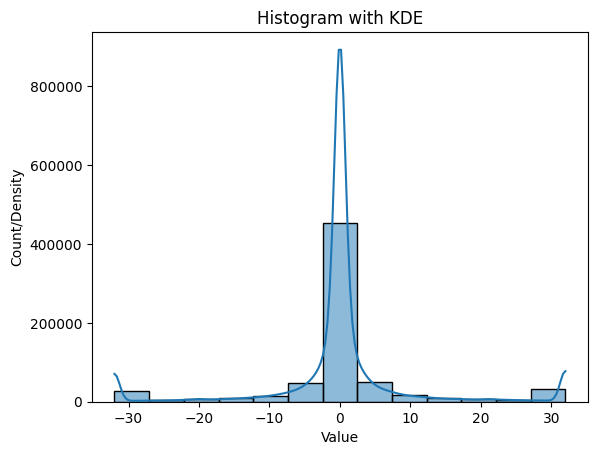

In [132]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(np.clip(data, -32, 32), bins=13, kde=True)

plt.xlabel("Value")
plt.ylabel("Count/Density")
plt.title("Histogram with KDE")

plt.show()


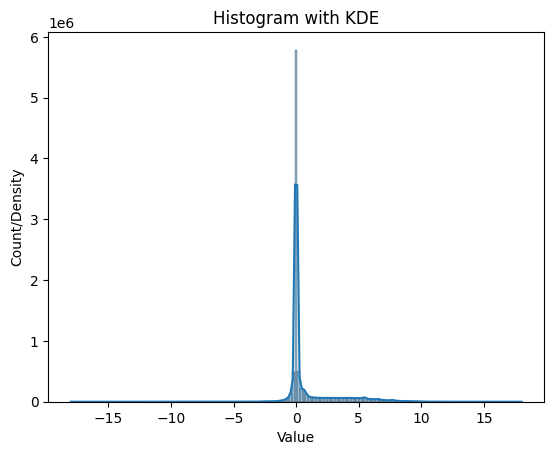

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(np.clip(data, -max_delta, max_delta), bins=169, kde=True)

plt.xlabel("Value")
plt.ylabel("Count/Density")
plt.title("Histogram with KDE")

plt.show()


In [8]:
np.savetxt("diff_data_2hz.txt", data, fmt="%.2f")

In [ ]:
np.set_printoptions()
np.quantile(motion_diffs, np.linspace(0, 1, num=256))

In [ ]:
# 2Hz from data
torch.tensor([-1.79992256e+01, -1.25670674e+00, -7.21364708e-01, -5.07658333e-01,
       -3.84416224e-01, -3.04407624e-01, -2.47120679e-01, -2.04565203e-01,
       -1.72141619e-01, -1.46730423e-01, -1.26084934e-01, -1.09246254e-01,
       -9.52895755e-02, -8.36043865e-02, -7.37621784e-02, -6.53941631e-02,
       -5.81548627e-02, -5.18672551e-02, -4.63345947e-02, -4.14485931e-02,
       -3.71436924e-02, -3.33337784e-02, -2.99460331e-02, -2.69252542e-02,
       -2.42061914e-02, -2.17624089e-02, -1.95732117e-02, -1.75766945e-02,
       -1.57730951e-02, -1.41465834e-02, -1.26628166e-02, -1.13086550e-02,
       -1.00836893e-02, -8.96141910e-03, -7.92952128e-03, -6.98988220e-03,
       -6.12676525e-03, -5.33930381e-03, -4.61196866e-03, -3.94487381e-03,
       -3.34494158e-03, -2.79329755e-03, -2.29477244e-03, -1.85000233e-03,
       -1.44801636e-03, -1.08355202e-03, -7.70907101e-04, -4.89056110e-04,
       -2.50136673e-04, -7.51291669e-05,  5.83435185e-06,  1.35630097e-04,
        3.63349915e-04,  6.22148434e-04,  9.35570770e-04,  1.27543140e-03,
        1.65974057e-03,  2.08234787e-03,  2.56383410e-03,  3.10235536e-03,
        3.69267941e-03,  4.34846644e-03,  5.05604031e-03,  5.84459305e-03,
        6.70039654e-03,  7.63360284e-03,  8.65932607e-03,  9.77272913e-03,
        1.09857286e-02,  1.23265757e-02,  1.37868475e-02,  1.53955745e-02,
        1.71767619e-02,  1.91293880e-02,  2.12938455e-02,  2.36873627e-02,
        2.63572636e-02,  2.93265646e-02,  3.26156534e-02,  3.63178253e-02,
        4.04899730e-02,  4.51892777e-02,  5.04722595e-02,  5.64718267e-02,
        6.33583350e-02,  7.12383084e-02,  8.04010526e-02,  9.12246704e-02,
        1.03970508e-01,  1.19276106e-01,  1.37971855e-01,  1.60842587e-01,
        1.88892627e-01,  2.23770142e-01,  2.66945052e-01,  3.20224638e-01,
        3.84690855e-01,  4.59728803e-01,  5.40342331e-01,  6.19781821e-01,
        6.98291898e-01,  7.90696874e-01,  9.28649435e-01,  1.11821511e+00,
        1.33377831e+00,  1.56634077e+00,  1.81162685e+00,  2.06730967e+00,
        2.32399494e+00,  2.58101989e+00,  2.83971087e+00,  3.10016251e+00,
        3.35723746e+00,  3.62190613e+00,  3.88414423e+00,  4.14529991e+00,
        4.40036220e+00,  4.66608620e+00,  4.93764699e+00,  5.21094166e+00,
        5.45412052e+00,  5.71091680e+00,  6.07024384e+00,  6.47147369e+00,
        6.87432291e+00,  7.50230487e+00,  8.26398438e+00,  1.79999180e+01])

tensor([   -17.9992,     -1.2567,     -0.7214,     -0.5077,     -0.3844,
            -0.3044,     -0.2471,     -0.2046,     -0.1721,     -0.1467,
            -0.1261,     -0.1092,     -0.0953,     -0.0836,     -0.0738,
            -0.0654,     -0.0582,     -0.0519,     -0.0463,     -0.0414,
            -0.0371,     -0.0333,     -0.0299,     -0.0269,     -0.0242,
            -0.0218,     -0.0196,     -0.0176,     -0.0158,     -0.0141,
            -0.0127,     -0.0113,     -0.0101,     -0.0090,     -0.0079,
            -0.0070,     -0.0061,     -0.0053,     -0.0046,     -0.0039,
            -0.0033,     -0.0028,     -0.0023,     -0.0019,     -0.0014,
            -0.0011,     -0.0008,     -0.0005,     -0.0003,     -0.0001,
             0.0000,      0.0001,      0.0004,      0.0006,      0.0009,
             0.0013,      0.0017,      0.0021,      0.0026,      0.0031,
             0.0037,      0.0043,      0.0051,      0.0058,      0.0067,
             0.0076,      0.0087,      0.0098,     

In [10]:
verlet_indices

tensor([14650,  1170,  1429,  1537,  1749,  1951,  2051,  1924,  1876,  1552,
         1411,  1203, 14185,  1121,   145,   156,   188,   241,   247,   268,
          276,   242,   152,   144,   129,  1092,  1230,   155,   211,   269,
          292,   326,   391,   343,   296,   243,   207,   178,  1278,  1583,
          208,   243,   313,   393,   428,   578,   507,   423,   320,   243,
          209,  1522,  2599,   312,   397,   535,   729,   827,  1150,   969,
          741,   543,   426,   315,  2393,  4310,   561,   736,   913,  1245,
         1919,  2743,  1941,  1387,   924,   743,   532,  4266,  7770,   998,
         1279,  1714,  2376,  3952,  6838,  3861,  2455,  1751,  1308,   942,
         7864,  4540,   519,   774,   990,  1359,  2097,  3158,  2077,  1354,
         1007,   748,   608,  4581,  2443,   297,   405,   536,   683,   950,
         1154,   827,   641,   564,   396,   305,  2452,  1558,   189,   272,
          320,   390,   450,   555,   451,   372,   373,   251, 

In [81]:
verlet_indices[:-1].argmax()

tensor(70)

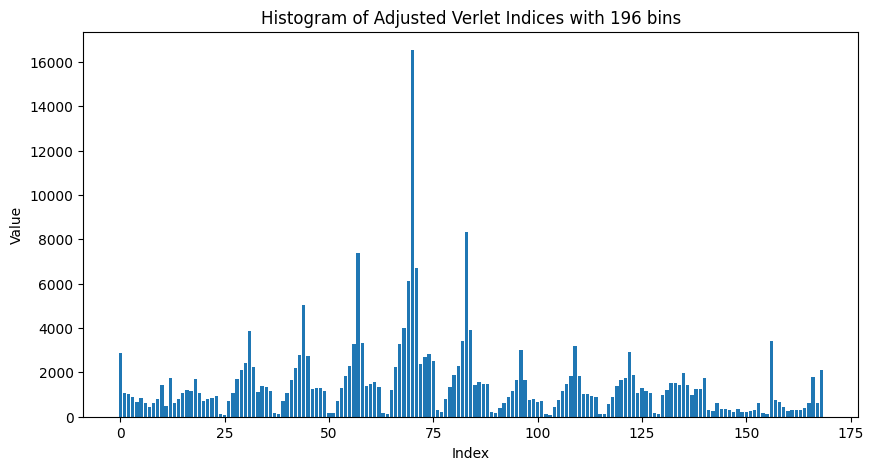

In [197]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(torch.arange(len(verlet_indices) - 1), verlet_indices[:-1])

# Labels and title
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Histogram of Adjusted Verlet Indices with 196 bins")

# Show the plot
plt.show()

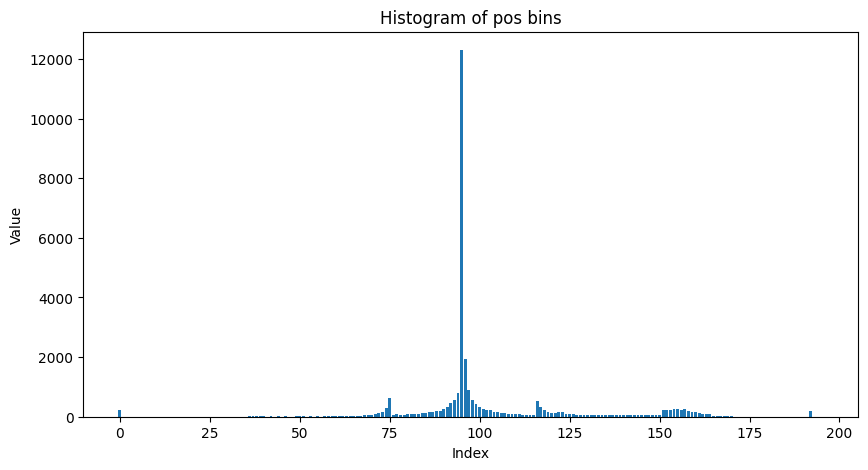

In [189]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(torch.arange(len(last_tokens) - 1), last_tokens[:-1])

# Labels and title
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Histogram of pos bins")

# Show the plot
plt.show()

In [13]:
decoder.pos_bins[50]

tensor(    0.0000)